In [1]:
import numpy as np
import matplotlib.pyplot as plt

class Cfg:
    # ----- Layout -----
    V = 4            # variables: x, dx, th, dth
    B = 6            # bins per variable
    Lp = 10           # program (genome) size (rows=cols=Lp)
    Ls = 5           # spacing after program (on both axes)
    Lis = 4          # inter-bin / inter-variable spacing (>=2)

    # ----- Time -----
    T = 120           # GoL micro-steps per control step
    steps_per_gen = 200
    n_gens = 30

    # ----- Population / GA -----
    N = 200
    elitism_E = 40
    tournament_k = 4
    p_cross = 0.05      # uniform crossover prob per cell (genome)
    p_mut = 4e-3        # pointwise bit-flip on genome
    seed = 0

    # ----- Force decode -----
    b = 1.0
    gain = 10.0
    sigma_F = 0.1
    F_clip = 10.0

    # ----- Cart-pole -----
    g = 9.8
    masscart = 1.0
    masspole = 0.1
    length = 0.5
    tau = 0.02
    x_threshold = 2.4
    theta_threshold = 12.0 * np.pi / 180.0

    # ----- Binning clamp ranges -----
    Lx = 2.4
    Ldx = 3.0
    Lth = theta_threshold
    Ldth = 4.0

    # ----- Logging / viz -----
    report_every = 40
    viz_layout = True  # keep ON: draws the layout masks to verify positions

cfg = Cfg()
np.random.seed(cfg.seed)


Grid size (Ly, Lx): 40 52


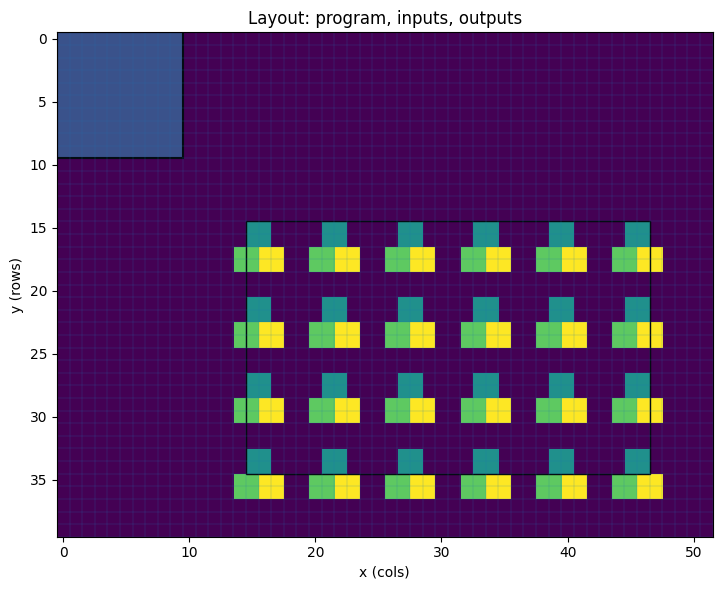

In [2]:
def build_layout(cfg: Cfg):
    # Input region dimensions
    Lix = cfg.B * 2 + (cfg.B - 1) * cfg.Lis
    Liy = cfg.V * 2 + (cfg.V - 1) * cfg.Lis

    # Total grid (rectangular, wrapping)
    Lx = cfg.Lp + cfg.Ls + Lix + cfg.Ls
    Ly = cfg.Lp + cfg.Ls + Liy + cfg.Ls
    assert cfg.Lp + cfg.Ls >= 1, "Need at least 1 col before left-shifted L blocks."

    # Anchors
    r_in = cfg.Lp + cfg.Ls
    c_in = cfg.Lp + cfg.Ls

    # Index helpers
    def var_rows(v):
        r0 = r_in + v * (2 + cfg.Lis)
        return r0, r0 + 1

    def bin_cols(k):
        c0 = c_in + k * (2 + cfg.Lis)
        return c0, c0 + 1

    # Masks
    L_mask = np.zeros((Ly, Lx), dtype=bool)
    R_mask = np.zeros((Ly, Lx), dtype=bool)
    input_mask = np.zeros((Ly, Lx), dtype=bool)
    program_slice = (slice(0, cfg.Lp), slice(0, cfg.Lp))

    for v in range(cfg.V):
        r0, r1 = var_rows(v)
        # Output rows are two below inputs
        rL0, rL1 = r0 + 2, r1 + 2
        for k in range(cfg.B):
            c0, c1 = bin_cols(k)
            # Input 2x2 (for viz only; inputs are written at t=0)
            input_mask[r0, c0] = input_mask[r0, c1] = True
            input_mask[r1, c0] = input_mask[r1, c1] = True
            # Left output: shift -1 col from input left edge
            lc0, lc1 = c0 - 1, c0
            L_mask[rL0, lc0] = L_mask[rL0, lc1] = True
            L_mask[rL1, lc0] = L_mask[rL1, lc1] = True
            # Right output: shift +1 col from input right edge
            rc0, rc1 = c1, c1 + 1
            R_mask[rL0, rc0] = R_mask[rL0, rc1] = True
            R_mask[rL1, rc0] = R_mask[rL1, rc1] = True

    # Basic sanity
    assert not (L_mask & input_mask).any(), "L mask overlaps inputs; increase Ls/Lis."
    assert not (R_mask & input_mask).any(), "R mask overlaps inputs; increase Ls/Lis."

    layout = dict(
        Lx=Lx, Ly=Ly, Lix=Lix, Liy=Liy,
        r_in=r_in, c_in=c_in,
        program_slice=program_slice,
        var_rows=var_rows, bin_cols=bin_cols,
        L_mask=L_mask, R_mask=R_mask, input_mask=input_mask
    )
    return layout

layout = build_layout(cfg)
print("Grid size (Ly, Lx):", layout["Ly"], layout["Lx"])


def plot_layout(layout, cfg: Cfg, title="Layout: program, inputs, outputs"):
    Ly, Lx = layout["Ly"], layout["Lx"]
    grid = np.zeros((Ly, Lx), dtype=np.int32)
    # 1: program region
    ps = layout["program_slice"]
    grid[ps] = 1
    # 2: input mask (for reference)
    grid[layout["input_mask"]] = np.maximum(grid[layout["input_mask"]], 2)
    # 3: L mask
    grid[layout["L_mask"]] = np.maximum(grid[layout["L_mask"]], 3)
    # 4: R mask
    grid[layout["R_mask"]] = np.maximum(grid[layout["R_mask"]], 4)

    plt.figure(figsize=(8, 6))
    plt.imshow(grid, origin='upper', interpolation='nearest')
    plt.title(title)
    plt.xlabel("x (cols)"); plt.ylabel("y (rows)")
    # Draw program border
    y0, y1 = ps[0].start, ps[0].stop
    x0, x1 = ps[1].start, ps[1].stop
    plt.gca().add_patch(plt.Rectangle((x0-0.5, y0-0.5), x1-x0, y1-y0, fill=False, linewidth=1.5))
    # Draw input region border
    plt.gca().add_patch(plt.Rectangle((layout["c_in"]-0.5, layout["r_in"]-0.5),
                                      layout["Lix"], layout["Liy"], fill=False, linewidth=1.0))
    # Light grid lines
    for r in range(Ly+1): plt.hlines(r-0.5, -0.5, Lx-0.5, linewidth=0.15)
    for c in range(Lx+1): plt.vlines(c-0.5, -0.5, Ly-0.5, linewidth=0.15)
    plt.tight_layout()
    plt.show()

if cfg.viz_layout:
    plot_layout(layout, cfg)


In [ ]:
def init_genomes(cfg: Cfg):
    # Genome is only the Lp×Lp program patch
    G = (np.random.rand(cfg.N, cfg.Lp, cfg.Lp) < 0.17)
    return G

def reset_env_states(n):
    return np.random.uniform(low=-0.07, high=0.07, size=(n, 4))

def reset_runtime_grid(S, G, layout):
    # S is (N, Ly, Lx), G is (N, Lp, Lp)
    S[:] = False
    ps = layout["program_slice"]
    S[:, ps[0], ps[1]] = G
    return S

# Allocate runtime arrays
G = init_genomes(cfg)
S = np.zeros((cfg.N, layout["Ly"], layout["Lx"]), dtype=bool)
state = reset_env_states(cfg.N)
alive = np.ones(cfg.N, dtype=bool)
fitness = np.zeros(cfg.N, dtype=np.int32)


In [ ]:
def to_bin_idx(val, L, B):
    x = np.clip(val, -L, L)
    k = np.floor(B * (x + L) / (2 * L)).astype(np.int32)
    return np.clip(k, 0, B - 1)

def encode_inputs(S, state, cfg: Cfg, layout):
    # Called once at t=0 of each control step
    x, dx, th, dth = state[:, 0], state[:, 1], state[:, 2], state[:, 3]
    ks = np.stack([
        to_bin_idx(x,  cfg.Lx,  cfg.B),
        to_bin_idx(dx, cfg.Ldx, cfg.B),
        to_bin_idx(th, cfg.Lth, cfg.B),
        to_bin_idx(dth,cfg.Ldth,cfg.B),
    ], axis=1)  # (N,4)

    for v in range(cfg.V):
        r0, r1 = layout["var_rows"](v)
        c0_all = layout["bin_cols"](ks[:, v])  # returns pair if scalar; we’ll vectorize below
        # vectorized columns per agent
        c0 = layout["c_in"] + ks[:, v]*(2 + cfg.Lis)
        c1 = c0 + 1
        idx = np.arange(S.shape[0])
        S[idx, r0, c0] = True; S[idx, r0, c1] = True
        S[idx, r1, c0] = True; S[idx, r1, c1] = True
    return S


def plot_ca_simple(S2d):
    arr = S2d.astype(np.uint8, copy=True)
    plt.imshow(arr, cmap='gray', vmin=0, vmax=1, interpolation='nearest')
    plt.axis('off')
    plt.show()

In [ ]:
def gol_step(S: np.ndarray) -> np.ndarray:
    up     = np.roll(S, -1, axis=1).astype(np.uint8, copy=False)
    down   = np.roll(S,  1, axis=1).astype(np.uint8, copy=False)
    left   = np.roll(S, -1, axis=2).astype(np.uint8, copy=False)
    right  = np.roll(S,  1, axis=2).astype(np.uint8, copy=False)
    uleft  = np.roll(up,   -1, axis=2)
    uright = np.roll(up,    1, axis=2)
    dleft  = np.roll(down, -1, axis=2)
    dright = np.roll(down,  1, axis=2)
    N = up + down + left + right + uleft + uright + dleft + dright
    Sb = S.astype(bool, copy=False)
    stay = Sb & ((N == 2) | (N == 3))
    born = (~Sb) & (N == 3)
    return stay | born

def run_CA(S, T):
    for mt in range(T):
        
        S = gol_step(S)
        
    return S


In [ ]:
def decode_force(S, layout, cfg: Cfg, return_counts=False):
    L = S[:, layout["L_mask"]].sum(axis=1).astype(np.float64)
    R = S[:, layout["R_mask"]].sum(axis=1).astype(np.float64)
    denom = L + R + cfg.b
    F = cfg.gain * (R - L) / denom
    if cfg.sigma_F > 0:
        F += np.random.normal(0.0, cfg.sigma_F, size=F.shape)
    F = np.clip(F, -cfg.F_clip, cfg.F_clip)
    return (F, L, R) if return_counts else F


In [ ]:
def cartpole_step(state, force, cfg: Cfg):
    x, x_dot, theta, theta_dot = state[:,0], state[:,1], state[:,2], state[:,3]
    total_mass = cfg.masspole + cfg.masscart
    polemass_length = cfg.masspole * cfg.length

    costheta = np.cos(theta);  sintheta = np.sin(theta)
    temp = (force + polemass_length * theta_dot * theta_dot * sintheta) / total_mass
    thetaacc = (cfg.g * sintheta - costheta * temp) / (
        cfg.length * (4.0/3.0 - cfg.masspole * costheta * costheta / total_mass)
    )
    xacc = temp - polemass_length * thetaacc * costheta / total_mass

    x         = x + cfg.tau * x_dot
    x_dot     = x_dot + cfg.tau * xacc
    theta     = theta + cfg.tau * theta_dot
    theta_dot = theta_dot + cfg.tau * thetaacc

    new_state = np.stack([x, x_dot, theta, theta_dot], axis=1)
    done = (np.abs(x) > cfg.x_threshold) | (np.abs(theta) > cfg.theta_threshold)
    return new_state, done


In [ ]:
def rank_by_fitness(fitness):
    return np.argsort(-fitness)  # descending

def tournament_select(fitness, k, n):
    N = fitness.shape[0]
    winners = np.empty(n, dtype=np.int32)
    for i in range(n):
        cand = np.random.randint(0, N, size=k)
        winners[i] = cand[np.argmax(fitness[cand])]
    return winners

def crossover_uniform(par1, par2, p_cross):
    mask = (np.random.rand(*par1.shape) < p_cross)
    return np.where(mask, par1, par2)

def mutate_bits(G, p_mut):
    mut = (np.random.rand(*G.shape) < p_mut)
    return G ^ mut

def next_generation(G, fitness, cfg: Cfg):
    order = rank_by_fitness(fitness)
    elites = G[order[:cfg.elitism_E]].copy()

    n_children = cfg.N - cfg.elitism_E
    parents = tournament_select(fitness, cfg.tournament_k, 2 * n_children)
    p1 = G[parents[:n_children]]
    p2 = G[parents[n_children:]]

    children = crossover_uniform(p1, p2, cfg.p_cross)
    children = mutate_bits(children, cfg.p_mut)

    G_new = np.concatenate([elites, children], axis=0)
    assert G_new.shape == G.shape
    return G_new


In [ ]:
def run_training(G,cfg: Cfg, layout):
    history = []

    for gen in range(cfg.n_gens):
        S = np.zeros((cfg.N, layout["Ly"], layout["Lx"]), dtype=bool)
        state = reset_env_states(cfg.N)
        alive = np.ones(cfg.N, dtype=bool)
        fitness = np.zeros(cfg.N, dtype=np.int32)

        for step in range(cfg.steps_per_gen):
            # Reset runtime grid to genome + inject inputs (t=0 only)
            S = reset_runtime_grid(S, G, layout)
            S = encode_inputs(S, state, cfg, layout)

            # Evolve CA
            S = run_CA(S, cfg.T)

            # Decode -> force; step env
            F, Lc, Rc = decode_force(S, layout, cfg, return_counts=True)
            state, done_step = cartpole_step(state, F, cfg)
            alive &= (~done_step)
            fitness += alive.astype(np.int32)

            if (step % cfg.report_every) == 0:
                #plot_ca_simple(S[0])
                print(f"[gen {gen:02d} step {step:03d}] "
                      f"alive={int(alive.sum())}/{cfg.N}  "
                      f"mean_fitness={fitness.mean():.2f}  "
                      f"MAX: L={Lc.max():.1f} R={Rc.max():.1f} F={F.max():.3f}")

        best = int(fitness.max())
        mean = float(fitness.mean())
        history.append((best, mean))
        print(f"==> Generation {gen} done: best={best} mean={mean:.2f}")

        # GA on genomes only
        G = next_generation(G, fitness, cfg)

    return history, G


In [ ]:
def plot_fitness(history):
    if not history: return
    best = [b for b, m in history]
    mean = [m for b, m in history]
    xs = np.arange(len(history))
    plt.figure(figsize=(6,4))
    plt.plot(xs, best, label="best")
    plt.plot(xs, mean, label="mean")
    plt.title("Fitness per generation")
    plt.xlabel("generation"); plt.ylabel("timesteps survived")
    plt.legend()
    plt.tight_layout()
    plt.show()


In [ ]:
# Small test run (adjust to taste)
cfg_small = cfg
G = init_genomes(cfg)
history, G_final = run_training(G, cfg_small, layout)
plot_fitness(history)


In [ ]:
# --- CA + CartPole videos (reuse existing modules) ---------------------------------------------
# Reuses from your notebook: cfg, layout, G, and functions:
#   reset_env_states, reset_runtime_grid, encode_inputs, gol_step, decode_force, cartpole_step
#
# Outputs (current folder):
#   - ca_full.mp4    (CA evolution, one frame per micro-step)
#   - cartpole.mp4   (Cart-pole render, one frame per control step)

import os
import numpy as np
import imageio.v2 as iio
import matplotlib.pyplot as plt

# --------------------- helpers ---------------------
def _to_uint8_frame(S2d: np.ndarray) -> np.ndarray:
    """bool/0-1 grid -> uint8 grayscale [0,255]."""
    if S2d.dtype != np.uint8:
        S2d = S2d.astype(np.uint8, copy=False)
    return S2d * 255

def _nearest_multiple(x, m):
    return ((x + m - 1) // m) * m

def _pad_gray(img2d_u8: np.ndarray, m: int) -> np.ndarray:
    """Pad a 2D uint8 image so H,W are multiples of m (constant 0)."""
    h, w = img2d_u8.shape
    H = _nearest_multiple(h, m); W = _nearest_multiple(w, m)
    if H == h and W == w:
        return img2d_u8
    out = np.zeros((H, W), dtype=np.uint8)
    out[:h, :w] = img2d_u8
    return out

def _pad_rgb(img_u8: np.ndarray, m: int) -> np.ndarray:
    """Pad an HxWx3 uint8 image so H,W are multiples of m (white bg)."""
    h, w, c = img_u8.shape
    H = _nearest_multiple(h, m); W = _nearest_multiple(w, m)
    if H == h and W == w:
        return img_u8
    out = np.ones((H, W, c), dtype=np.uint8) * 255
    out[:h, :w] = img_u8
    return out

def _scale_nearest_gray(img2d_u8: np.ndarray, scale: int) -> np.ndarray:
    """Integer nearest-neighbor upscaling (fast)."""
    if scale == 1:
        return img2d_u8
    return np.repeat(np.repeat(img2d_u8, scale, axis=0), scale, axis=1)

def _write_video(frames, path, fps: int = 12, macro_block_size: int = 16, is_rgb: bool = False):
    """Write frames to MP4 (H.264), padding to macro-block size to avoid ffmpeg resizing."""
    if not frames:
        raise ValueError("No frames to write.")
    d = os.path.dirname(path)
    if d:
        os.makedirs(d, exist_ok=True)
    with iio.get_writer(path, fps=fps, codec="libx264", quality=8) as w:
        for f in frames:
            if is_rgb:
                f = _pad_rgb(f, macro_block_size)
                w.append_data(f)
            else:
                f = _pad_gray(f, macro_block_size)
                f = np.stack([f, f, f], axis=-1)
                w.append_data(f)
    return os.path.abspath(path)

def _render_cartpole_frame(state_i, cfg, width: int = 384, height: int = 256) -> np.ndarray:
    """
    Render a simple cart-pole frame to an RGB uint8 array using Matplotlib.
    Uses a safe buffer extraction that works across backends.
    """
    x, x_dot, theta, theta_dot = state_i

    dpi = 96
    fig = plt.figure(figsize=(width/dpi, height/dpi), dpi=dpi)
    ax = fig.add_axes([0, 0, 1, 1])
    ax.set_xlim(-cfg.x_threshold*1.1, cfg.x_threshold*1.1)
    ax.set_ylim(-0.3, 1.0)
    ax.axis('off')

    # Track
    ax.plot([-cfg.x_threshold*1.1, cfg.x_threshold*1.1], [0, 0], linewidth=2)

    # Cart
    cart_y = 0.1; cart_w = 0.3; cart_h = 0.15
    ax.add_patch(plt.Rectangle((x - cart_w/2, cart_y - cart_h/2), cart_w, cart_h, fill=True))

    # Pole
    pole_len = cfg.length * 2.0
    px = x + pole_len * np.sin(theta)
    py = cart_y + cart_h/2 + pole_len * np.cos(theta)
    ax.plot([x, px], [cart_y + cart_h/2, py], linewidth=3)

    # Safe buffer extraction: draw, then use RGBA buffer
    fig.canvas.draw()
    w, h = fig.canvas.get_width_height()
    buf = np.frombuffer(fig.canvas.buffer_rgba(), dtype=np.uint8).reshape(h, w, 4)
    img = buf[..., :3].copy()  # drop alpha
    plt.close(fig)
    return img

# --------------------- main simulate & video ---------------------
def simulate_and_video(cfg, layout, G, steps_per_run: int = 40, agent: int = 0,
                       fps_ca: int = 12, fps_cp: int = 12, scale: int = 8,
                       macro_block_size: int = 16,
                       ca_path: str = "ca_full.mp4",
                       cartpole_path: str = "cartpole.mp4"):
    """
    Runs a single-agent rollout and saves:
      - CA video (per micro-step), upscaled by `scale`.
      - Cart-pole video (per control step), rendered RGB.
    """
    N = G.shape[0]
    agent_idx = agent % N  # guard against out-of-range indices

    Ly, Lx = layout["Ly"], layout["Lx"]
    S = np.zeros((N, Ly, Lx), dtype=bool)
    state = reset_env_states(N)

    frames_ca = []
    frames_cp = []

    for step in range(steps_per_run):
        # Reset CA grid to genome; inject inputs at t=0 only
        S = reset_runtime_grid(S, G, layout)
        S = encode_inputs(S, state, cfg, layout)

        # Evolve CA and record micro-steps
        for _ in range(cfg.T):
            S = gol_step(S)
            s2d = S[agent_idx]
            f = _to_uint8_frame(s2d)
            if scale != 1:
                f = _scale_nearest_gray(f, scale)
            frames_ca.append(f)

        # Decode -> force; step environment
        F = decode_force(S, layout, cfg)
        state, done = cartpole_step(state, F, cfg)

        # Render one cart-pole frame per control step
        frames_cp.append(_render_cartpole_frame(state[agent_idx], cfg))

    out_ca = _write_video(frames_ca, ca_path, fps=fps_ca, macro_block_size=macro_block_size, is_rgb=False)
    out_cp = _write_video(frames_cp, cartpole_path, fps=fps_cp, macro_block_size=macro_block_size, is_rgb=True)
    print("Saved:", out_ca, "and", out_cp)
    return {"ca": out_ca, "cartpole": out_cp}

# --------------------- EXECUTE (same cell) ---------------------
# Adjust args as desired; agent can be any int (wrapped modulo N).
paths = simulate_and_video(cfg, layout, G_final, steps_per_run=300, agent=150, fps_ca=48, fps_cp=24, scale=8)
paths
